In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.ticker as tick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
from scipy.stats import linregress
from scipy.signal import savgol_filter
import scipy.ndimage as img
import peakutils.peak as peak
import cv2 as cv
import urllib.request as urlr
from jupyterthemes import jtplot

In [22]:
jtplot.reset()
# plt.switch_backend("TkAgg")
plt.style.use("seaborn-poster")
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.figsize"] = (5*16/9, 5)
plt.rcParams["figure.dpi"] = 100

In [25]:
class Spectrometer:
    
    def __init__(self, calibrationLocation, calibrationWavelengths, lowerx=None, upperx=None, lowery=None, uppery=None, lowerBound=350, upperBound=750):
        def pixelLocation(wavelength):
            pl = (wavelength - self.calibration_yIntercept)/self.calibrationSlope
            return np.round(pl).astype(int)
        
        m, b, R, p, sd = linregress(calibrationLocation, calibrationWavelengths)
        
        self.calibrationLocation = calibrationLocation
        self.calibrationWavelengths = calibrationWavelengths
        self.calibrationSlope = m
        self.calibration_yIntercept = b
        self.calibration_lincorr = R**2
        self.lowerBound = lowerBound
        self.upperBound = upperBound
        if lowery is None:
            self.start = pixelLocation(lowerBound)
            self.end = pixelLocation(upperBound)
        else:
            self.start = lowery
            self.end = uppery
        self.upperx = upperx
        self.lowerx = lowerx
        self.count = 0
        
    
    def plotCalibration(self, save=False):
        x = self.calibrationLocation
        y = self.calibrationWavelengths
        m = self.calibrationSlope
        b = self.calibration_yIntercept
        
        fig = plt.figure()
        
        ax = fig.add_subplot(111)
        ax.plot(x, y, "o")
        ax.set_xlabel("pixel location")
        ax.set_ylabel("wavelength [nm]")
        
        m, b, R, p, sd = linregress(x, y)
        if b > 0:
            fitlabel = r"$y = %.2fx + %.2f$, $R^2 = %.3f$"%(m, b, R**2)
        else:
            fitlabel = r"$y = %.2fx - %.2f$, $R^2 = %.3f$"%(m, abs(b), R**2)
        ax.plot(x, m*x + b, label=fitlabel)
        
        plt.legend(framealpha=0)
        if save:
            plt.savefig("calibcurve.png", dpi=300, bbox_inches="tight")
        plt.show()
        
    def LineScan_snapshot(self, image_name, peaks=False, window_length=3, polyorder=2, save=False):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", DeprecationWarning)
            image = img.imread(image_name, mode="L")
        
        profile = image[1040:1050, self.start:self.end]
        fig = plt.figure(figsize=(5*16/9*2, 5))
        
        ax = fig.add_subplot(121)
        ax.imshow(image, cmap ='gray', origin="lower")
        ax.set_title(image_name[:-4])
        ax.grid(False)
        
        ax = fig.add_subplot(122)
        wav = np.linspace(self.upperBound, self.lowerBound, self.end-self.start)
        norm_profile = savgol_filter(profile[5]/profile[5].max(), window_length, polyorder)        
        ax.plot(wav, norm_profile, 'r-', lw = 1.5)
        ax.set_ylabel('rel. intensity')
        ax.set_xlabel('wavelength [nm]')
        ax.set_xlim(wav.min(), wav.max())
        ax.set_ylim(norm_profile.min()-0.01, norm_profile.max()+0.2)
        if peaks:
            peaks = peak.indexes(np.array(norm_profile), thres = 0.2, min_dist = 15)    
            ax.plot(wav[peaks], norm_profile[peaks], "k.")
#             print('Peak Wavelengths are at ' + str(wav[peaks]) + ' nm')  
            
        in_ax = inset_axes(ax, width="100%", height="2.75%", loc="upper center")
        in_ax.imshow(profile[:, ::-1], cmap = 'gray', origin="lower")
        in_ax.grid(False)
        in_ax.axis("off")
        
        wavp = wav[peaks]
        normp = norm_profile[peaks]
        for i in range(len(wavp)):
            ax.text(wavp[i], normp[i]+0.03, "%.2f"%(wavp[i]), ha="center", fontsize=18)
            
        if save:
            plt.savefig(image_name[:-4] + ".png", dpi=300, bbox_inches="tight")
        plt.show()

    def continue_loop(self):
        while True:
            self.count += 1
            yield self.count
        
    def update(self, continue_loop):
        imgResp = urlr.urlopen(self.URL)
        img_arr = np.array(bytearray(imgResp.read()), dtype=np.uint8)
        img = cv.imdecode(img_arr, -1)
        image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        self.profile = image[self.lowerx:self.upperx, self.end:self.start]
        try:
            self.norm_profile = savgol_filter(self.profile[5]/self.profile[5].max(), self.window_length, self.polyorder)
        except np.linalg.LinAlgError:
            pass
        wav = np.linspace(self.lowerBound, self.upperBound, len(self.norm_profile))
        if self.show_peaks:
            peaks = peak.indexes(np.array(self.norm_profile), thres = 0.2, min_dist = 15)    

        self.livecam.set_data(image)
        self.line.set_xdata(wav)
        self.line.set_ydata(self.norm_profile)
        self.scanref.set_data(self.profile)
        self.peakplt.set_xdata(wav[peaks])
        self.peakplt.set_ydata(self.norm_profile[peaks])
        return self.livecam, self.line, self.scanref, self.peakplt
            
    def LineScan_live(self, URL, show_peaks=False, window_length=3, polyorder=2):
        imgResp = urlr.urlopen(URL)
        img_arr = np.array(bytearray(imgResp.read()), dtype=np.uint8)
        img = cv.imdecode(img_arr, -1)
        image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Data initilization
        profile = image[self.lowerx:self.upperx, self.end:self.start]
        norm_profile = savgol_filter(profile[5]/profile[5].max(), window_length, polyorder)
        wav = np.linspace(self.lowerBound, self.upperBound, len(norm_profile))
        
        self.fig = plt.figure(figsize=(5*16/9, 5))
        
        # Axes 1 setup (live feed)
        self.ax1 = self.fig.add_subplot(121)
        self.ax1.grid(False)
        
        # Axes 2 setup (intensity profile)
        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_ylabel('rel. intensity')
        self.ax2.set_xlabel('wavelength [nm]')
        self.ax2.set_xlim(wav.min(), wav.max())
        self.ax2.set_ylim(0.0, norm_profile.max()+0.25)
        
        # Inset axes setup (line scan reference)
        self.in_ax = inset_axes(self.ax2, width="100%", height="10%", loc="upper center")
        self.in_ax.grid(False)
        self.in_ax.axis("off")

        self.livecam = self.ax1.imshow(image, cmap ='gray')
        self.line, = self.ax2.plot(wav, norm_profile, 'r-', lw = 1.5)
        self.scanref = self.in_ax.imshow(profile, cmap = 'gray', origin="lower")
        
        if show_peaks:
            peaks = peak.indexes(np.array(norm_profile), thres = 0.1, min_dist = 15)    
            self.peakplt, = self.ax2.plot(wav[peaks], norm_profile[peaks], "ko")
#             print('Peak Wavelengths are at ' + str(wav[peaks]) + ' nm')  
        
#         self.data_text = self.ax1.text(0, 1.0, "", transform=self.ax1.transformAxes)
    
        self.image = image
        self.norm_profile = norm_profile
        self.wav = wav
        self.URL = URL
        self.window_length = window_length
        self.polyorder = polyorder
        self.show_peaks = show_peaks
    
#         self.fig.canvas.mpl_connect("key_press_event", self.on_key)
        ani = anim.FuncAnimation(self.fig, self.update, self.continue_loop)
        plt.tight_layout()
        plt.show(block=1)
        
        
# loc = np.array([2715, 2584, 2476, 2428, 1994, 1591])
# loc = np.array([740, 927, 1129, 1151, 1202, 1262])
# loc = np.array([733, 906, 1087, 1107, 1154, 1207])
loc = np.array([736, 903, 1086, 1108, 1152, 1206])
# loc = np.array([1206, 1152, 1108, 1086, 903, 736])
# lamda = np.array([388.86, 446.14, 471.31, 501.57, 584.33, 667.8])
lamda = np.array([667.8, 584.33, 501.57, 471.31, 446.14, 388.36])

### HELIUM
He_loc = np.array([1877, 1918, 1955, 1972, 2120, 2266])
He_lambda = np.array([388.86, 446.14, 471.31, 501.57, 584.33, 667.8])

### HYDROGEN
#Pixel_Location = [2174, 2281, 2637]
#Wavelength = [434, 486.1, 656.2]

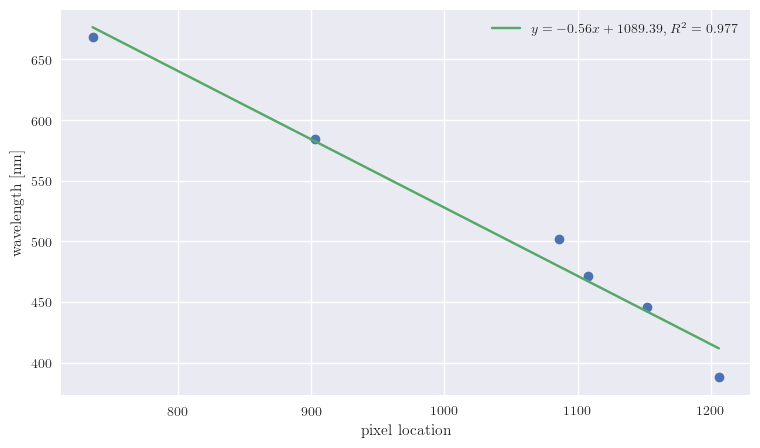

In [6]:
URL = "http://192.168.42.100:8080/shot.jpg"
spec = Spectrometer(loc, lamda, 560, 570)
spec.plotCalibration()
# spec.LineScan_live(URL, True, 15, 2)

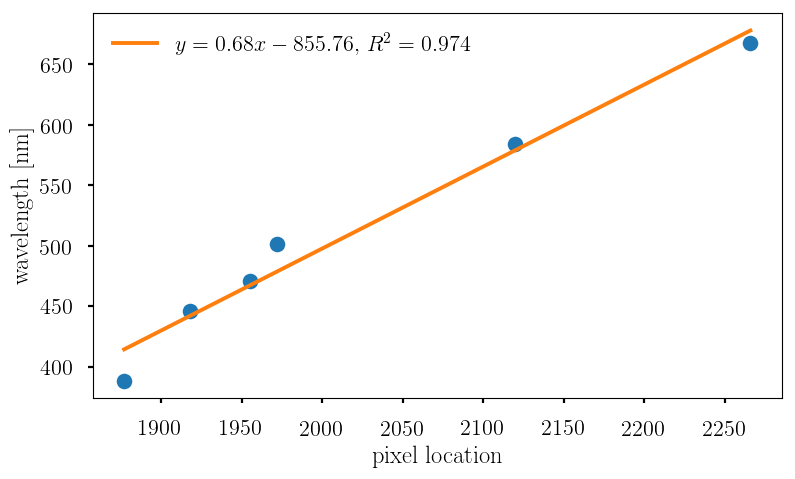

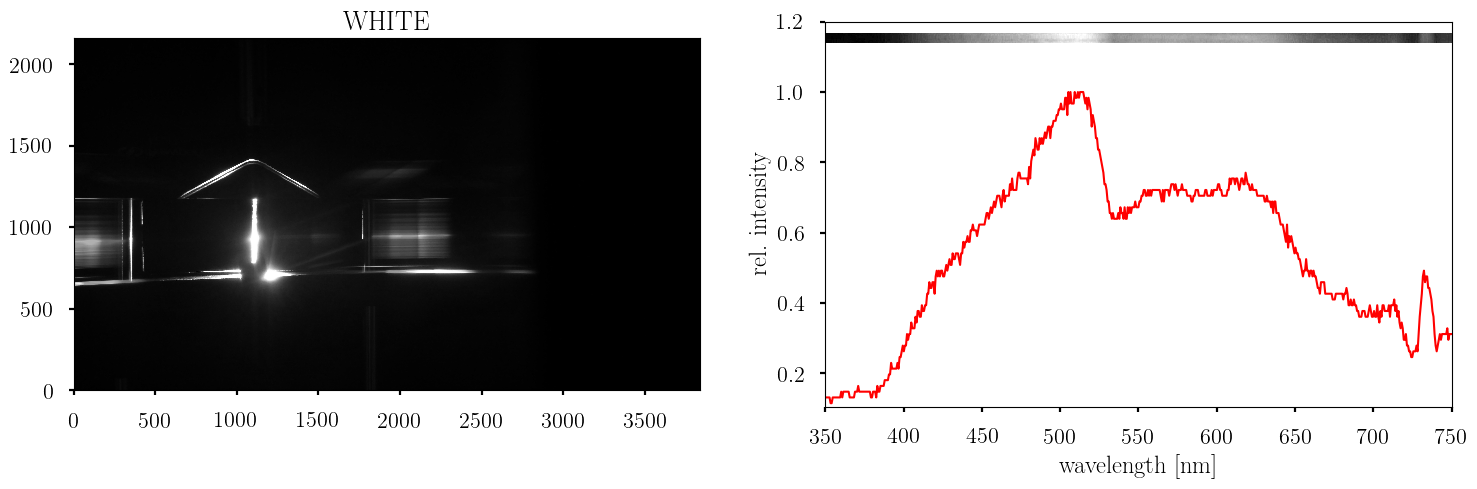

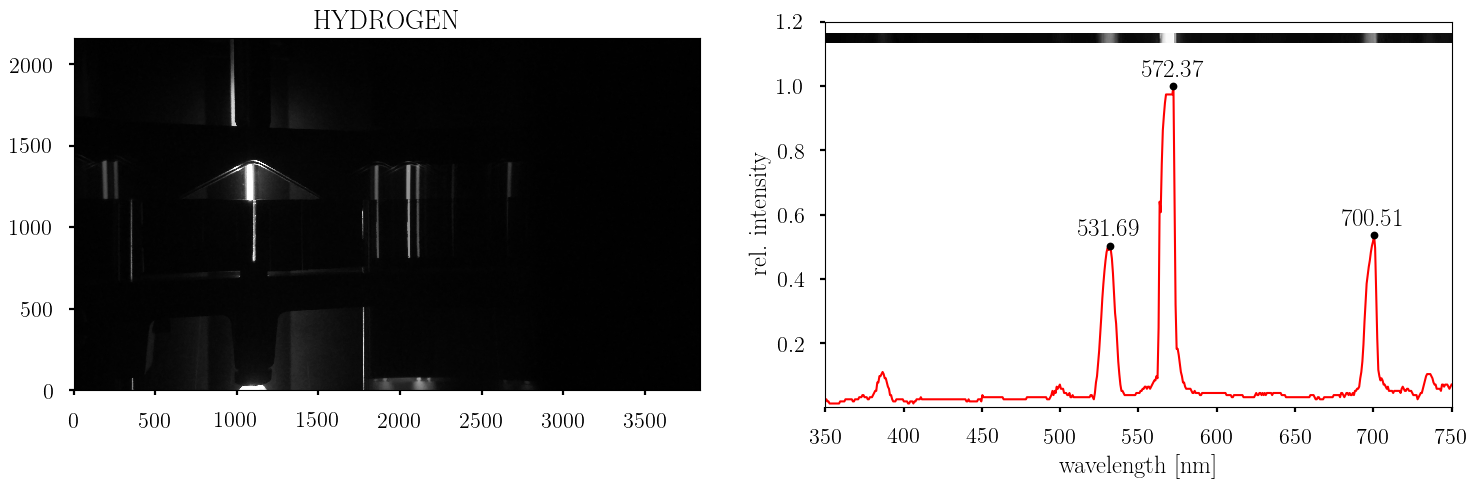

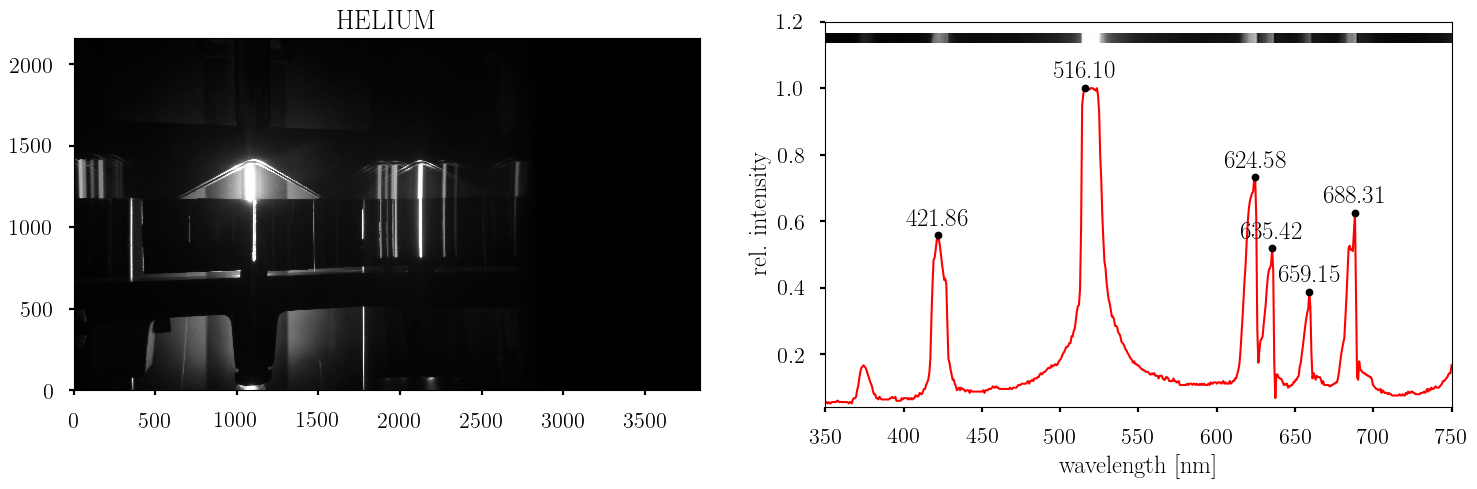

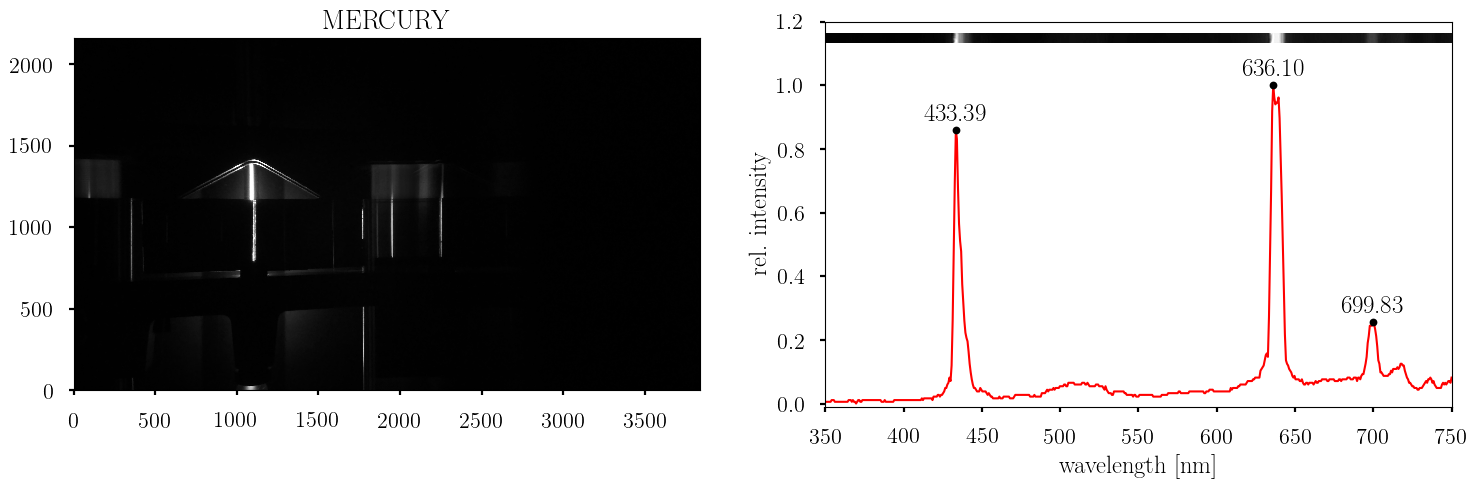

In [26]:
spec = Spectrometer(He_loc, He_lambda)
spec.plotCalibration(True)
spec.LineScan_snapshot("WHITE.jpg", False, 3, 2, True)
spec.LineScan_snapshot("HYDROGEN.jpg", True, 3, 2, True)
spec.LineScan_snapshot("HELIUM.jpg", True, 3, 2, True)
spec.LineScan_snapshot("MERCURY.jpg", True, 3, 2, True)